In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

%config InlineBackend.figure_format = 'retina'

## Exploratory Data Analysis for Tree Survival Prediction

This project uses TreeO2 data to understand and predict tree survival rates across different farms in Timor-Leste. Survival outcomes are explored through charts and visual analysis alongside environmental conditions such as rainfall, temperature, soil pH, elevation, and slope to identify patterns, risks, and limiting factors that affect tree survival. These insights are then used to train a machine learning model that predicts tree survival likelihood before planting, and helps field staff make better planting decisions.

### Load and combine TreeO2 data files

In [4]:
# Note: The Tree O2 files are available in MSTeams at: Planting optimisation tool > Shared > Datasets > Tree O2

# Load all Tree O2 CSV files
tree_files = [
    "/Users/cjaybasa/Documents/POT Data/Tree O2/Baguia_Trees_2025-11-25_038a64.csv",
    "/Users/cjaybasa/Documents/POT Data/Tree O2/CCC_Trees_2025-11-25_2da6c9.csv",
    "/Users/cjaybasa/Documents/POT Data/Tree O2/Lautem-Lospalos_Trees_2025-11-25_564e36.csv",
    "/Users/cjaybasa/Documents/POT Data/Tree O2/NETIL_Trees_2025-11-25_859919.csv",
    "/Users/cjaybasa/Documents/POT Data/Tree O2/Quelicai-Laga_Trees_2025-11-25_36be59.csv",
    "/Users/cjaybasa/Documents/POT Data/Tree O2/TV_Trees_2025-11-25_56c5f6.csv",
    "/Users/cjaybasa/Documents/POT Data/Tree O2/Viqueque, Uatucarbau, Uatulari_Trees_2025-11-25_4930fd.csv",
]

# Read each file and store in a list
df_list = []

for f in tree_files:
    df_tmp = pd.read_csv(f, dtype=str, low_memory=False)
    df_list.append(df_tmp)

# Combine all TreeO2 files into one DataFrame
treeo2_df = pd.concat(df_list, ignore_index=True)

### Load and combine TreeO2 (Dec 5) data files

In [6]:
# Note: The TreeO2 (Dec 5) files are available in MSTeams at: Planting optimisation tool > Shared > Datasets > TreeO2 (Dec 5)

# Load all TreeO2 (Dec 5) CSV files
new_tree_files = [
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS4210_Baguia_Tree_Data_1.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS4210_Baguia_Tree_Data_2.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS4210_Baguia_Tree_Data_3.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS4210_Baguia_Tree_Data_4.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS4210_Baguia_Tree_Data_5.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS4210_Baguia_Tree_Data_6.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS11743_CCC_Covalima_Tree_Data (1).csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS11800_TV_Baucau_Tree_Data (1).csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/GS11801_NETIL_Liquica_Tree_Data (1).csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/RM_Lautem-Lospalos_Tree_Data.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/RM_Quelicai-Laga_Tree_Data.csv",
    "/Users/cjaybasa/Documents/POT Data/TreeO2 (Dec 5)/RM_Viqueque-Uatucarbau-Uatulari_Tree_Data.csv",
]

# Read each file and store in a list
df_new_list = []

for f in new_tree_files:
    df_new_tmp = pd.read_csv(f, dtype=str, low_memory=False)

    # Add farm column based on filename
    df_new_tmp["farm"] = os.path.basename(f).replace(".csv", "")

    df_new_list.append(df_new_tmp)

# Combine all TreeO2 (Dec 5) files into one DataFrame
treeo2_dec5_df = pd.concat(df_new_list, ignore_index=True)

### Load optimum environmental variables for species dataset

In [8]:
# Note: The file is available in MSTeams at: Planting optimisation tool > Shared > Datasets

optima_df = pd.read_excel(
    "/Users/cjaybasa/Documents/POT Data/Optimum Environmental Variables for species.xlsx"
)
optima_df.head()

,Sr. No.,Species Name,Common Name,Remark,Limiting factor,Soil Type,Rainfall (mm),Temperature (degree celsius),Soil PH,Altitude (meters),Reference,Unnamed: 11
0,1.0,Casuarina equisetifolia,Ai-kakeu,The tree is very tolerant of wind and salt spr...,"Clay soil, waterlogging","well drained sandy, or loamy soil",200-3500 mm,10-35,5.0-7.7,0-1400 m,https://apps.worldagroforestry.org/treedb/AFTP...,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,Tectona grandis,Ai-teka,"The teak tree grows best below 600 meters, tho...","dry sandy soil, acidic soil","Deep, well drained loamy soil",1500-2000,16-40,6.5-7.5,0-1200 m,1.https://apps.worldagroforestry.org/treedb/AF...,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,Pterocarpus indicus,Ai-na,The tree is well adapted to tropical regions w...,"Alkaline soil, high altitude",Sandy or Clay loam,900-2200,22-32,6.0-7.0,0-600,1. https://apps.worldagroforestry.org/treedb2/...,NaN


### Display the structure of each DataFrame

In [10]:
treeo2_df.info()
treeo2_dec5_df.info()
optima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459075 entries, 0 to 1459074
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   FobID                  1459075 non-null  object
 1   EarliestScanTimestamp  1459075 non-null  object
 2   LatestScanTimestamp    1459075 non-null  object
 3   ScanCount              1459075 non-null  object
 4   TreeTypeName           1459075 non-null  object
 5   EstimatedPlantedMonth  1459075 non-null  object
 6   EstimatedPlantedYear   1459075 non-null  object
 7   EstimatedPlatedDate    1459075 non-null  object
 8   Latitude               1425236 non-null  object
 9   Longitude              1425236 non-null  object
 10  TrunkDiameter          580804 non-null   object
 11  TrunkCircumference     580804 non-null   object
 12  Height                 96452 non-null    object
 13  CarbonDioxide          96452 non-null    object
 14  PhotoURL               0 non-null 

### Explore TreeO2 DataFrame

In [12]:
# Print information about the DataFrame
def data_overview(treeo2_df):
    # Print the shape (rows, columns)
    print("Shape:", treeo2_df.shape)

    # Print the data types of all columns
    print("\nColumn data types:")
    print(treeo2_df.dtypes)

    # Print the number of missing values in each column
    print("\nMissing values per column:")
    print(treeo2_df.isnull().sum())

    # Print the number of duplicate rows
    print("\nDuplicate rows count:")
    print(treeo2_df.duplicated().sum())

In [13]:
data_overview(treeo2_df)

Shape: (1459075, 22)

Column data types:
FobID                    object
EarliestScanTimestamp    object
LatestScanTimestamp      object
ScanCount                object
TreeTypeName             object
EstimatedPlantedMonth    object
EstimatedPlantedYear     object
EstimatedPlatedDate      object
Latitude                 object
Longitude                object
TrunkDiameter            object
TrunkCircumference       object
Height                   object
CarbonDioxide            object
PhotoURL                 object
FarmerCardID             object
FarmerName               object
FarmerStreetAddress      object
FarmerSuburbLocality     object
FarmerRegion             object
FarmerStateProvince      object
FarmerCountryCode        object
dtype: object

Missing values per column:
FobID                          0
EarliestScanTimestamp          0
LatestScanTimestamp            0
ScanCount                      0
TreeTypeName                   0
EstimatedPlantedMonth          0
EstimatedPlante

### Remove duplicate rows and check for any remaining duplicates

In [15]:
# Remove all duplicate rows from DataFrame and reset the index
treeo2_df = treeo2_df.drop_duplicates().reset_index(drop=True)

# Confirm that no duplicates remain
treeo2_df.duplicated().sum()

0

In [16]:
# Remove all duplicate rows from DataFrame and reset the index
treeo2_dec5_df = treeo2_dec5_df.drop_duplicates().reset_index(drop=True)

# Confirm that no duplicates remain
treeo2_dec5_df.duplicated().sum()

0

### Clean and prepare the TreeO2 dataset

In [18]:
# Fill missing species names with blank text
treeo2_df["TreeTypeName"] = treeo2_df["TreeTypeName"].fillna("")

# Remove everything inside the brackets
treeo2_df["TreeTypeName"] = treeo2_df["TreeTypeName"].str.replace(
    r"\(.*?\)", "", regex=True
)

# Remove all spaces
treeo2_df["TreeTypeName"] = treeo2_df["TreeTypeName"].str.replace(" ", "")

# Fix hyphen spacing (from Ai- mahony to Ai-mahony)
treeo2_df["TreeTypeName"] = treeo2_df["TreeTypeName"].str.replace("- ", "-")
treeo2_df["TreeTypeName"] = treeo2_df["TreeTypeName"].str.replace(" -", "-")

# Make the first letter uppercase and the rest lowercase
treeo2_df["TreeTypeName"] = treeo2_df["TreeTypeName"].str.capitalize()

# Convert the EarliestScanTimestamp column to the DateTime type
treeo2_df["EarliestScanTimestamp"] = pd.to_datetime(
    treeo2_df["EarliestScanTimestamp"], dayfirst=True, errors="coerce"
).dt.date

# Convert the LatestScanTimestamp column to the DateTime type
treeo2_df["LatestScanTimestamp"] = pd.to_datetime(
    treeo2_df["LatestScanTimestamp"], dayfirst=True, errors="coerce"
).dt.date

# Convert the LatestScanTimestamp column to the DateTime type
treeo2_df["EstimatedPlatedDate"] = pd.to_datetime(
    treeo2_df["EstimatedPlatedDate"], format="%Y/%m/%d", errors="coerce"
).dt.date

# Rename EstimatedPlatedDate column to EstimatedPlantedDate
treeo2_df = treeo2_df.rename(columns={"EstimatedPlatedDate": "EstimatedPlantedDate"})

# Convert -1 values in Latitude or Longitude to NaN
treeo2_df["Latitude"] = treeo2_df["Latitude"].replace("-1", pd.NA)
treeo2_df["Longitude"] = treeo2_df["Longitude"].replace("-1", pd.NA)

# Convert blanks "" in Latitude or Longitude to NaN
treeo2_df["Latitude"] = treeo2_df["Latitude"].replace("", pd.NA)
treeo2_df["Longitude"] = treeo2_df["Longitude"].replace("", pd.NA)

# Recompute the reference table using clean coordinates
farmer_reference = treeo2_df.groupby("FarmerCardID").agg(
    {
        "Latitude": "first",
        "Longitude": "first",
        "FarmerSuburbLocality": "first",
        "FarmerRegion": "first",
    }
)

# Identify farmers whose Latitude or Longitude is missing
missing_gps = treeo2_df[treeo2_df["Latitude"].isna() | treeo2_df["Longitude"].isna()][
    "FarmerCardID"
].unique()

# Identify farmers with missing suburb information
missing_suburb = treeo2_df[treeo2_df["FarmerSuburbLocality"].isna()][
    "FarmerCardID"
].unique()

# Identify farmers with missing region information
missing_region = treeo2_df[treeo2_df["FarmerRegion"].isna()]["FarmerCardID"].unique()

missing_gps, missing_suburb, missing_region

# Fill missing Latitude using the reference Latitude per farmer
treeo2_df["Latitude"] = treeo2_df["Latitude"].fillna(
    treeo2_df["FarmerCardID"].map(farmer_reference["Latitude"])
)

# Fill missing Longitude using reference Longitude per farmer
treeo2_df["Longitude"] = treeo2_df["Longitude"].fillna(
    treeo2_df["FarmerCardID"].map(farmer_reference["Longitude"])
)

# Fill missing suburb using reference Suburb per farmer
treeo2_df["FarmerSuburbLocality"] = treeo2_df["FarmerSuburbLocality"].fillna(
    treeo2_df["FarmerCardID"].map(farmer_reference["FarmerSuburbLocality"])
)

# Fill missing region using reference Region per farmer
treeo2_df["FarmerRegion"] = treeo2_df["FarmerRegion"].fillna(
    treeo2_df["FarmerCardID"].map(farmer_reference["FarmerRegion"])
)

# Drop rows with missing Latitude or Longitude
treeo2_df = treeo2_df.dropna(subset=["Latitude", "Longitude"])

# Show remaining missing values for Latitude, Longitude, FarmerSuburbLocality, and FarmerRegion
treeo2_df.isnull().sum()[
    ["Latitude", "Longitude", "FarmerSuburbLocality", "FarmerRegion"]
]

# De-identify farmer address fields
drop_columns = [
    "FarmerName",
    "FarmerStreetAddress",
    "FarmerSuburbLocality",
    "FarmerRegion",
    "FarmerStateProvince",
    "FarmerCountryCode",
]

treeo2_df = treeo2_df.drop(columns=drop_columns, errors="ignore")

# Save the CSV file
# treeo2_df.to_csv("/Users/cjaybasa/Downloads/filled_location_values_tree_data.csv", index=False)

# Display the first ten rows of the resulting DataFrame
treeo2_df.head()

,FobID,EarliestScanTimestamp,LatestScanTimestamp,ScanCount,TreeTypeName,EstimatedPlantedMonth,EstimatedPlantedYear,EstimatedPlantedDate,Latitude,Longitude,TrunkDiameter,TrunkCircumference,Height,CarbonDioxide,PhotoURL,FarmerCardID
0,00008831-cae7-49b4-9541-222bc8070b7e,2023-08-02,2023-08-03,1,Ai-mahony,4,2022,NaT,-8.6595658,126.7234809,NaN,NaN,NaN,NaN,NaN,1437251144
1,00008c49-44c7-4901-a279-c5a7a656425e,2023-08-14,2023-08-14,1,Ai-mahony,3,2021,NaT,-8.6360699,126.6485511,NaN,NaN,NaN,NaN,NaN,1430270536
2,0000b0ae-6ba7-4abd-a92c-f22c2ad4a278,2023-08-10,2023-08-10,1,Ai-kakeu,1,2022,NaT,-8.6383101,126.6215908,NaN,NaN,NaN,NaN,NaN,1437952584
3,00011c15-7661-4f95-adf4-498e1493ff68,2023-07-14,2023-07-14,1,Ai-teka,4,2019,NaT,-8.6254749,126.6495341,NaN,NaN,NaN,NaN,NaN,1431593032
4,0002e8a3-2099-4e6d-bb34-baf809800574,2023-07-02,2023-07-02,1,Ai-mahony,4,2021,NaT,-8.6357641,126.6711186,NaN,NaN,NaN,NaN,NaN,1439119176


### Clean and prepare the TreeO2 (Dec 5) dataset

In [20]:
# Fill missing species names with blank text
treeo2_dec5_df["tree_species"] = treeo2_dec5_df["tree_species"].fillna("")

# Remove everything inside the brackets
treeo2_dec5_df["tree_species"] = treeo2_dec5_df["tree_species"].str.replace(
    r"\(.*?\)", "", regex=True
)

# Remove all spaces
treeo2_dec5_df["tree_species"] = treeo2_dec5_df["tree_species"].str.replace(" ", "")

# Fix hyphen spacing (from Ai- mahony to Ai-mahony)
treeo2_dec5_df["tree_species"] = treeo2_dec5_df["tree_species"].str.replace("- ", "-")
treeo2_dec5_df["tree_species"] = treeo2_dec5_df["tree_species"].str.replace(" -", "-")

treeo2_dec5_df["tree_species"] = treeo2_dec5_df["tree_species"].str.capitalize()

# Convert -1 values in latitude or longitude to NaN
treeo2_dec5_df["latitude"] = treeo2_dec5_df["latitude"].replace("-1", pd.NA)
treeo2_dec5_df["longitude"] = treeo2_dec5_df["longitude"].replace("-1", pd.NA)

# Convert blanks "" in latitude or longitude to NaN
treeo2_dec5_df["latitude"] = treeo2_dec5_df["latitude"].replace("", pd.NA)
treeo2_dec5_df["longitude"] = treeo2_dec5_df["longitude"].replace("", pd.NA)

# Recompute the reference table using clean coordinates
farmer_reference = treeo2_dec5_df.groupby("farmer_card_id").agg(
    {"latitude": "first", "longitude": "first"}
)

# Identify farmers whose latitude or longitude is missing
missing_gps = treeo2_dec5_df[
    treeo2_dec5_df["latitude"].isna() | treeo2_dec5_df["longitude"].isna()
]["farmer_card_id"].unique()

missing_gps

# Fill missing latitude using the reference latitude per farmer
treeo2_dec5_df["latitude"] = treeo2_dec5_df["latitude"].fillna(
    treeo2_dec5_df["farmer_card_id"].map(farmer_reference["latitude"])
)

# Fill missing longitude using reference longitude per farmer
treeo2_dec5_df["longitude"] = treeo2_dec5_df["longitude"].fillna(
    treeo2_dec5_df["farmer_card_id"].map(farmer_reference["longitude"])
)

# Drop rows with missing latitude or longitude
treeo2_dec5_df = treeo2_dec5_df.dropna(subset=["latitude", "longitude"])

# Show remaining missing values for latitude and longitude
treeo2_dec5_df.isnull().sum()[["latitude", "longitude"]]

# Drop farm column
treeo2_dec5_df = treeo2_dec5_df.drop(columns=["farm"], errors="ignore")

# Display the first ten rows of the resulting DataFrame
treeo2_dec5_df.head()

,fob_id,scan_date,scanned_to_farmer_id,farmer_card_id,planted_year,planted_month,trunk_circumference,tree_species,latitude,longitude
0,00008831-cae7-49b4-9541-222bc8070b7e,2023-08-02,668,1437251144,2022,4,NaN,Ai-mahony,-8.6595658,126.7234809
1,00008c49-44c7-4901-a279-c5a7a656425e,2023-08-14,786,1430270536,2021,3,NaN,Ai-mahony,-8.6360699,126.6485511
2,0000b0ae-6ba7-4abd-a92c-f22c2ad4a278,2023-08-10,760,1437952584,2022,1,NaN,Ai-kakeu,-8.6383101,126.6215908
3,00011c15-7661-4f95-adf4-498e1493ff68,2023-07-14,1081,1431593032,2019,4,NaN,Ai-teka,-8.6254749,126.6495341
4,0002e8a3-2099-4e6d-bb34-baf809800574,2023-07-02,643,1439119176,2021,4,NaN,Ai-mahony,-8.6357641,126.6711186


### Clean and prepare optimum environmental variables dataset

In [22]:
# Clean species names
optima_df["species_name"] = optima_df["Common Name"].astype(str)

# Remove anything in brackets (e.g., Ai-kakau (mutin))
optima_df["species_name"] = optima_df["species_name"].str.replace(
    r"\(.*?\)", "", regex=True
)

# Only take text before slash (e.g., Candelnut/Ai-kamii to Candelnut)
optima_df["species_name"] = optima_df["species_name"].str.split("/").str[0]

# Strip spaces
optima_df["species_name"] = optima_df["species_name"].str.strip()

# Standardise lowercase to capitalise
optima_df["species_name"] = optima_df["species_name"].str.lower().str.capitalize()


# Funtion to clean numeric text
def clean_numeric_text(text):
    text = str(text)
    text = text.replace(" ", "")
    text = text.replace(",", "")
    text = text.replace("–", "-")
    text = text.replace("—", "-")
    return text


# Extract rainfall ranges
optima_df["rainfall_min"] = None
optima_df["rainfall_max"] = None

for i in range(len(optima_df)):
    text = clean_numeric_text(optima_df.loc[i, "Rainfall (mm)"])
    nums = re.findall(r"[\d\.]+", text)

    if len(nums) == 1:
        optima_df.loc[i, "rainfall_min"] = float(nums[0])
        optima_df.loc[i, "rainfall_max"] = float(nums[0])
    elif len(nums) >= 2:
        optima_df.loc[i, "rainfall_min"] = float(nums[0])
        optima_df.loc[i, "rainfall_max"] = float(nums[1])

# Extract temperature ranges
optima_df["temp_min"] = None
optima_df["temp_max"] = None

for i in range(len(optima_df)):
    text = clean_numeric_text(optima_df.loc[i, "Temperature (degree celsius)"])
    nums = re.findall(r"[\d\.]+", text)

    if len(nums) == 1:
        optima_df.loc[i, "temp_min"] = float(nums[0])
        optima_df.loc[i, "temp_max"] = float(nums[0])
    elif len(nums) >= 2:
        optima_df.loc[i, "temp_min"] = float(nums[0])
        optima_df.loc[i, "temp_max"] = float(nums[1])


# Fix automatically converted pH dates in Excel
def strip_year_from_ph(x):
    nums = re.findall(r"\d+\.?\d*", str(x))
    nums = [n for n in nums if float(n) <= 14]  # remove years
    if len(nums) >= 2:
        return f"{nums[0]}-{nums[1]}"
    elif len(nums) == 1:
        return nums[0]
    return x


optima_df["Soil PH"] = optima_df["Soil PH"].astype(str).apply(strip_year_from_ph)

# Extract pH ranges
optima_df["ph_min"] = None
optima_df["ph_max"] = None

for i in range(len(optima_df)):
    text = clean_numeric_text(optima_df.loc[i, "Soil PH"])
    nums = re.findall(r"[\d\.]+", text)

    nums = [float(n) for n in nums if float(n) <= 14]

    if len(nums) == 1:
        optima_df.loc[i, "ph_min"] = nums[0]
        optima_df.loc[i, "ph_max"] = nums[0]
    elif len(nums) >= 2:
        nums = sorted(nums)
        optima_df.loc[i, "ph_min"] = nums[0]
        optima_df.loc[i, "ph_max"] = nums[1]

# Extract altitude ranges
optima_df["alt_min"] = None
optima_df["alt_max"] = None

for i in range(len(optima_df)):
    text = clean_numeric_text(optima_df.loc[i, "Altitude (meters)"])
    nums = re.findall(r"[\d\.]+", text)

    if len(nums) == 1:
        optima_df.loc[i, "alt_min"] = float(nums[0])
        optima_df.loc[i, "alt_max"] = float(nums[0])
    elif len(nums) >= 2:
        optima_df.loc[i, "alt_min"] = float(nums[0])
        optima_df.loc[i, "alt_max"] = float(nums[1])

# Keep only these columns
optima_df = optima_df[
    [
        "species_name",
        "rainfall_min",
        "rainfall_max",
        "temp_min",
        "temp_max",
        "ph_min",
        "ph_max",
        "alt_min",
        "alt_max",
    ]
]

# Remove any other rows
optima_df = optima_df[optima_df["species_name"].str.lower() != "nan"]
optima_df = optima_df[optima_df["species_name"].str.strip() != ""]

optima_df = optima_df.reset_index(drop=True)

# Save final cleaned file
optima_df.to_csv("/Users/cjaybasa/Downloads/cleaned_optima.csv", index=False)

optima_df.head()

,species_name,rainfall_min,rainfall_max,temp_min,temp_max,ph_min,ph_max,alt_min,alt_max
0,Ai-kakeu,200.0,3500.0,10.0,35.0,5.0,7.7,0.0,1400.0
1,Ai-teka,1500.0,2000.0,16.0,40.0,6.5,7.5,0.0,1200.0
2,Ai-na,900.0,2200.0,22.0,32.0,6.0,7.0,0.0,600.0
3,Ai-kamelli,625.0,1625.0,10.0,35.0,6.0,7.5,50.0,1200.0
4,Ai-nitas,1100.0,1800.0,18.0,32.0,6.0,7.5,0.0,1000.0


### Display an overview of both TreeO2 datasets

In [24]:
# Show a summary of the DataFrame
data_overview(treeo2_df)
data_overview(treeo2_dec5_df)

Shape: (1458410, 16)

Column data types:
FobID                            object
EarliestScanTimestamp            object
LatestScanTimestamp              object
ScanCount                        object
TreeTypeName                     object
EstimatedPlantedMonth            object
EstimatedPlantedYear             object
EstimatedPlantedDate     datetime64[ns]
Latitude                         object
Longitude                        object
TrunkDiameter                    object
TrunkCircumference               object
Height                           object
CarbonDioxide                    object
PhotoURL                         object
FarmerCardID                     object
dtype: object

Missing values per column:
FobID                          0
EarliestScanTimestamp     183950
LatestScanTimestamp       183950
ScanCount                      0
TreeTypeName                   0
EstimatedPlantedMonth          0
EstimatedPlantedYear           0
EstimatedPlantedDate     1458410
Latitude     

### Calculate matching accuracy between TreeO2 datasets

In [26]:
# Take a 3% sample from each dataset for testing the merge
treeo2_dec5 = treeo2_dec5_df.sample(frac=0.03, random_state=42).copy()
treeo2_old = treeo2_df.sample(frac=0.03, random_state=42).copy()

# Merge the sampled datasets on shared key columns
merge_df = treeo2_dec5.merge(
    treeo2_old,
    how="left",
    left_on=["farmer_card_id", "tree_species", "planted_year", "planted_month"],
    right_on=[
        "FarmerCardID",
        "TreeTypeName",
        "EstimatedPlantedYear",
        "EstimatedPlantedMonth",
    ],
)

# Create a column indicating whether each row found a match
merge_df["matched"] = merge_df["FobID"].notna()

# Count matched and unmatched rows, plus their proportions
match_counts = merge_df["matched"].value_counts()
match_percent = merge_df["matched"].value_counts(normalize=True)

# Print match results
print(
    f"The number of rows successfully matched is {match_counts.get(True, 0)} "
    f"({match_percent.get(True, 0) * 100:.2f}%)"
)
print(
    f"The number of rows unsuccessfully matched is {match_counts.get(False, 0)} "
    f"({match_percent.get(False, 0) * 100:.2f}%)\n"
)

# Keep only matched rows and remove the match indicator column
matched_df = merge_df[merge_df["matched"]].drop(columns=["matched"])

The number of rows successfully matched is 732219 (98.73%)
The number of rows unsuccessfully matched is 9423 (1.27%)



### Find the nearest farm for each tree and assign the farm’s environmental conditions

In [28]:
# Load farm environmental dataset
farm_env_df = pd.read_csv(
    "/Users/cjaybasa/Downloads/farms_environmental_conditions.csv"
)

# Rename correct latitude and longitude columns in both datasets
matched_df = matched_df.rename(
    columns={"latitude": "tree_lat", "longitude": "tree_lon"}
)

farm_env_df = farm_env_df.rename(
    columns={"latitude": "farm_lat", "longitude": "farm_lon"}
)

# Convert to numeric
matched_df["tree_lat"] = pd.to_numeric(matched_df["tree_lat"], errors="coerce")
matched_df["tree_lon"] = pd.to_numeric(matched_df["tree_lon"], errors="coerce")
farm_env_df["farm_lat"] = pd.to_numeric(farm_env_df["farm_lat"], errors="coerce")
farm_env_df["farm_lon"] = pd.to_numeric(farm_env_df["farm_lon"], errors="coerce")

matched_df = matched_df.dropna(subset=["tree_lat", "tree_lon"])
farm_env_df = farm_env_df.dropna(subset=["farm_lat", "farm_lon"])


# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c


# Nearest farm matching
farm_coords = farm_env_df[["farm_lat", "farm_lon"]].values

nearest_index = []
nearest_distance = []

for _, row in matched_df.iterrows():
    distances = haversine(
        row["tree_lat"], row["tree_lon"], farm_coords[:, 0], farm_coords[:, 1]
    )
    i = np.argmin(distances)
    nearest_index.append(i)
    nearest_distance.append(distances[i])

matched_df["nearest_farm_index"] = nearest_index
matched_df["distance_to_farm_km"] = nearest_distance

# Merge environmental data
farm_env_df = farm_env_df.reset_index().rename(columns={"index": "nearest_farm_index"})
final_df = matched_df.merge(farm_env_df, on="nearest_farm_index", how="left")

# Create canonical species name column
species_map = {"Ai-bubur": "Ai-bobur", "Ai-kamelii": "Ai-kamelli"}

final_df["correct_tree_species_name"] = (
    final_df["tree_species"]
    .replace(species_map)
    .astype(str)
    .str.strip()
    .str.lower()
    .str.capitalize()
)

# Save result
# final_df.to_csv("/Users/cjaybasa/Downloads/tree_farm_environment_merged.csv", index=False)

# Match quality summary
close_matches = final_df[final_df["distance_to_farm_km"] < 2]
far_matches = final_df[final_df["distance_to_farm_km"] >= 2]

# Calculate the total trees in final dataset
total = len(final_df)

print(
    f"The number of trees located within 2 km of the nearest farm is "
    f"{len(close_matches)} ({len(close_matches) / total:.2%})"
)

print(
    f"The number of trees located 2 km or more from the nearest farm is "
    f"{len(far_matches)} ({len(far_matches) / total:.2%})"
)

The number of trees located within 2 km of the nearest farm is 702117 (95.89%)
The number of trees located 2 km or more from the nearest farm is 30102 (4.11%)


### Calculate the total number of trees that survived

In [30]:
# Convert timestamp to datetime
final_df["LatestScanTimestamp"] = pd.to_datetime(
    final_df["LatestScanTimestamp"], errors="coerce", dayfirst=True
)

# Convert planted year to numeric
final_df["planted_year"] = pd.to_numeric(final_df["planted_year"], errors="coerce")

# Convert measurement columns to numeric
numeric_cols = ["TrunkDiameter", "TrunkCircumference", "Height", "trunk_circumference"]
for col in numeric_cols:
    final_df[col] = pd.to_numeric(final_df[col], errors="coerce")

# Extract year of latest scan
final_df["latest_scan_year"] = final_df["LatestScanTimestamp"].dt.year

# Create the survived column using basic rules
final_df["survived"] = (
    (final_df["latest_scan_year"] >= final_df["planted_year"] + 1)
    | (final_df["TrunkDiameter"] > 0)
    | (final_df["TrunkCircumference"] > 0)
    | (final_df["Height"] > 0)
    | (final_df["trunk_circumference"] > 0)
).astype(int)

# Count how many trees survived and not survived
survived_counts = final_df["survived"].value_counts()

# Get proportions (percentage) of survived vs not survived
survived_percent = final_df["survived"].value_counts(normalize=True)

# Print results
print(
    f"The number of trees that survived is {survived_counts.get(1, 0)} "
    f"({survived_percent.get(1, 0):.2%})"
)

print(
    f"The number of trees that did not survive is {survived_counts.get(0, 0)} "
    f"({survived_percent.get(0, 0):.2%})"
)

# Save final dataset with survived column
final_df.to_csv("/Users/cjaybasa/Downloads/tree_farm_data.csv", index=False)

The number of trees that survived is 692374 (94.56%)
The number of trees that did not survive is 39845 (5.44%)


### Identify the top 10 farmers with 100% tree survival

In [32]:
# Calculate survival stats per farmer
farmer_stats = (
    final_df.groupby("farmer_card_id")
    .agg(total_trees=("survived", "size"), survived_trees=("survived", "sum"))
    .reset_index()
)

# Calculate survival rate
farmer_stats["survival_rate"] = (
    farmer_stats["survived_trees"] / farmer_stats["total_trees"] * 100
)

# Identify farmers with 100% tree survival
top_10_full_survival = (
    farmer_stats[farmer_stats["survival_rate"] == 100]
    .sort_values("total_trees", ascending=False)
    .head(10)
)

# Calculate mean environmental conditions per farmer
farmer_env_means = (
    final_df.groupby("farmer_card_id")
    .agg(
        mean_temp=("temp_mean", "mean"),
        mean_rain=("rain_mean", "mean"),
        mean_ph=("ph", "mean"),
        mean_slope=("slope_mean", "mean"),
        mean_elev=("elev_mean", "mean"),
    )
    .reset_index()
)

# Merge survival statistics with environmental means
top_10_full_survival = top_10_full_survival.merge(
    farmer_env_means, on="farmer_card_id", how="left"
)

top_10_full_survival

,farmer_card_id,total_trees,survived_trees,survival_rate,mean_temp,mean_rain,mean_ph,mean_slope,mean_elev
0,1337721611,16153,16153,100.0,23.201326,2141.748539,6.262750,29.665821,691.662660
1,1442510664,14731,14731,100.0,25.345407,2020.840843,6.999477,8.312147,153.266377
2,1435064152,13637,13637,100.0,25.330222,1380.980744,7.703212,1.599101,358.476589
3,1433555528,13632,13632,100.0,23.067508,2153.428657,6.200000,30.597616,731.611394
4,1429745736,11692,11692,100.0,23.074977,2152.156584,6.203079,30.561044,728.874763
5,1438004808,10470,10470,100.0,24.289537,2553.609375,7.406972,14.378532,381.902731
6,1433727816,9829,9829,100.0,23.068634,2152.663943,6.200000,30.604405,730.750000
7,1330575627,9746,9746,100.0,25.228870,1912.923977,8.137944,1.829864,100.891773
8,1435412552,9482,9482,100.0,24.363838,2548.525671,7.921388,17.826863,405.040831
9,1431363656,8688,8688,100.0,25.385266,1380.146679,7.800000,1.676537,365.487922


### Identify the bottom 10 farmers with 0% tree survival

In [34]:
# Calculate survival stats per farmer
farmer_stats = (
    final_df.groupby("farmer_card_id")
    .agg(total_trees=("survived", "size"), survived_trees=("survived", "sum"))
    .reset_index()
)

# Calculate tree survival rate
farmer_stats["survival_rate"] = (
    farmer_stats["survived_trees"] / farmer_stats["total_trees"] * 100
)

# Identify farmers with zero surviving trees
bottom_10_zero_survival = farmer_stats[farmer_stats["survived_trees"] == 0]

# Calculate mean environmental conditions per farmer
farmer_env_means = (
    final_df.groupby("farmer_card_id")
    .agg(
        mean_temp=("temp_mean", "mean"),
        mean_rain=("rain_mean", "mean"),
        mean_ph=("ph", "mean"),
        mean_slope=("slope_mean", "mean"),
        mean_elev=("elev_mean", "mean"),
    )
    .reset_index()
)

# Merge survival statistics with environmental means
bottom_10_zero_survival = (
    bottom_10_zero_survival.merge(farmer_env_means, on="farmer_card_id", how="left")
    .sort_values("total_trees", ascending=False)
    .head(10)
)

bottom_10_zero_survival

,farmer_card_id,total_trees,survived_trees,survival_rate,mean_temp,mean_rain,mean_ph,mean_slope,mean_elev
53,1433080920,1338,0,0.0,25.249560,1967.688752,8.171300,6.919317,255.671749
64,1434199640,963,0,0.0,24.829054,1967.688752,8.200000,2.935067,206.125000
3,1339887627,567,0,0.0,23.169785,1706.912404,6.200000,16.298877,842.178571
1,1328342043,500,0,0.0,24.144625,1967.688752,8.200000,17.591718,567.622200
120,1442062168,456,0,0.0,24.184511,1862.305257,7.800000,8.457688,546.857143
75,1435667544,387,0,0.0,23.163631,1710.217228,6.105426,18.180434,867.690102
58,1433864280,380,0,0.0,24.039799,1967.688752,8.200000,9.913411,584.142857
33,1429689432,329,0,0.0,23.170255,1706.912404,6.200000,17.231048,915.879850
99,1438926920,322,0,0.0,24.829054,1967.688752,8.200000,4.695445,209.532609
105,1440165448,255,0,0.0,23.834658,1967.688752,8.200000,9.391111,625.666667


### Visualise tree survival by species

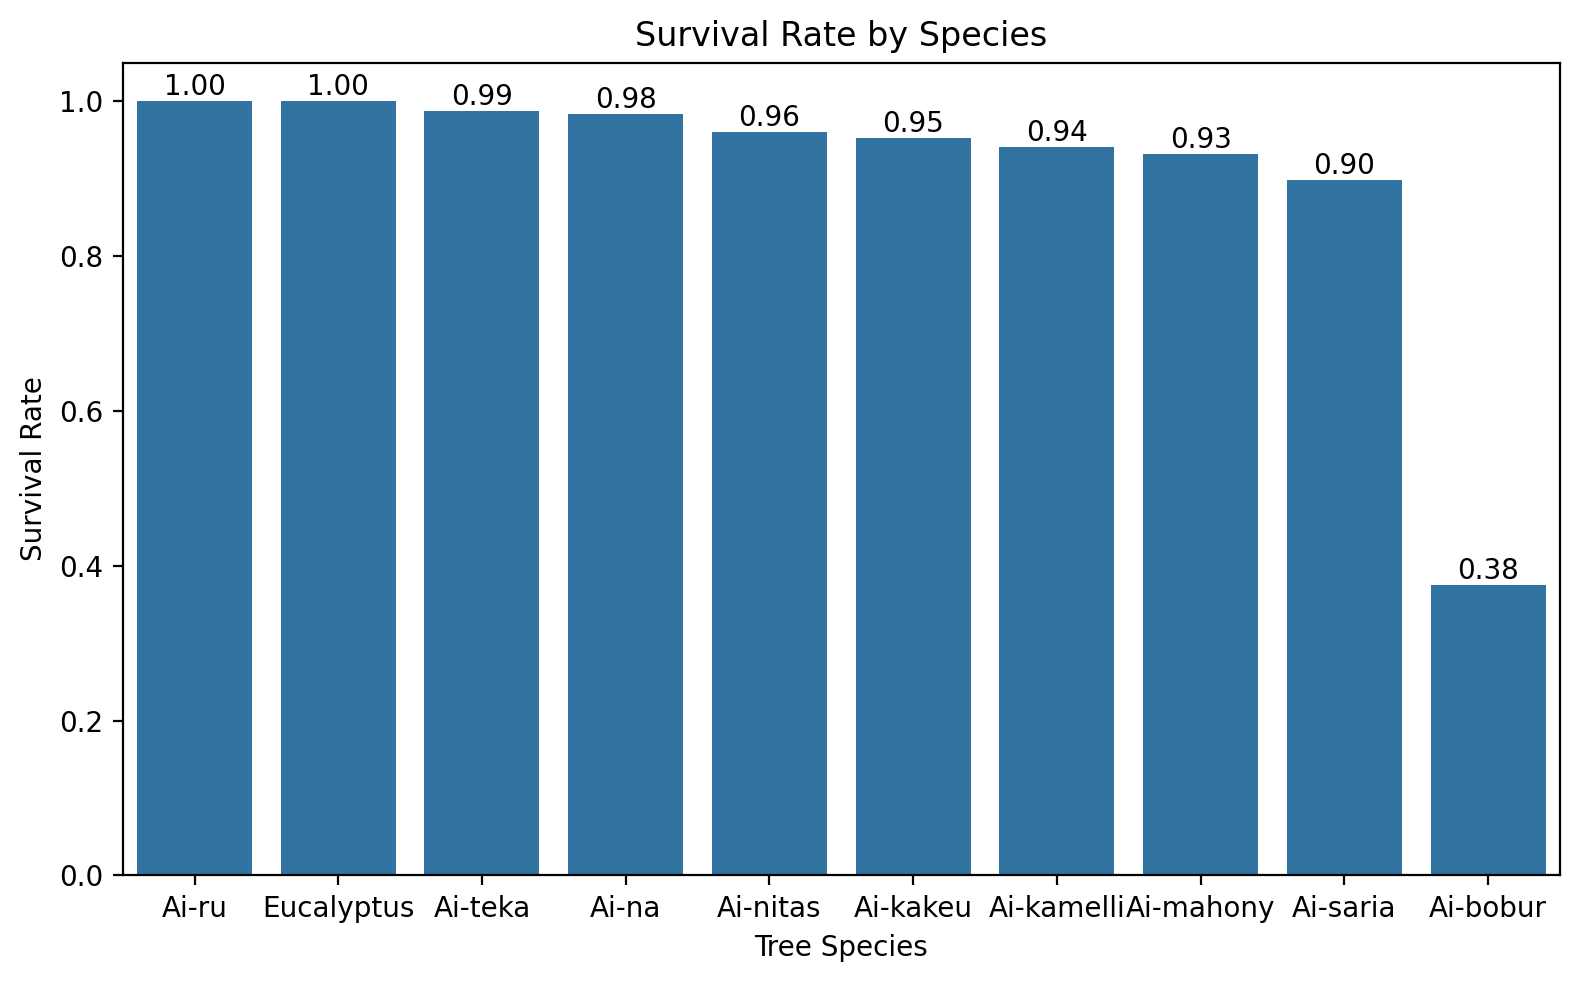

In [36]:
# Group the data by correct_tree_species_name, calculate the mean survival rate for each species, and sort the results in descending order
species_survival = (
    final_df.groupby("correct_tree_species_name")["survived"]
    .mean()
    .sort_values(ascending=False)
)

# Initialise the plot size for the visualisation
plt.figure(figsize=(8, 5))

# Create a bar plot using Seaborn, mapping tree species names to the x-axis and mean survival rates to the y-axis
ax = sns.barplot(x=species_survival.index, y=species_survival.values)

# Add numerical data labels (survival rates) on top of each bar in the plot
for i, v in enumerate(species_survival.values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set the labels and title for the chart
plt.ylabel("Survival Rate")
plt.xlabel("Tree Species")
plt.title("Survival Rate by Species")
plt.tight_layout()

# Display the generated plot
plt.show()

### Visualise tree survival by altitude range

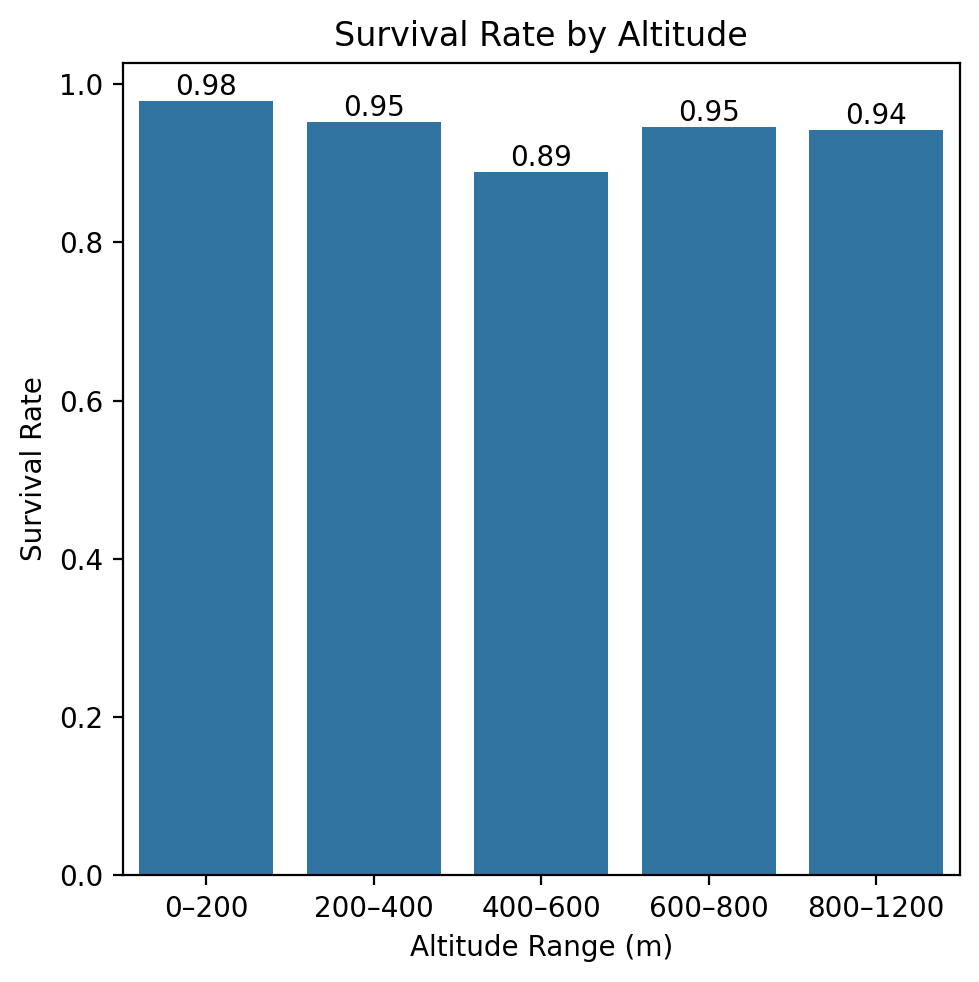

In [38]:
# Create a temporary DataFrame for altitude analysis, dropping rows missing the elev_mean data
df_alt = final_df.dropna(subset=["elev_mean"])

# Bin the continuous elev_mean data into categorical ranges using pandas.cut
df_alt["altitude_bin"] = pd.cut(
    df_alt["elev_mean"],
    bins=[0, 200, 400, 600, 800, 1200],
    labels=["0–200", "200–400", "400–600", "600–800", "800–1200"],
)

# Group the data by the newly created altitude bins and calculate the average survival rate for each bin
alt_survival = df_alt.groupby("altitude_bin", observed=False)["survived"].mean()

# Initialise the plot size for the visualisation
plt.figure(figsize=(5, 5))

# Create a bar plot using Seaborn, mapping altitude bins to the x-axis and mean survival rates to the y-axis
ax = sns.barplot(x=alt_survival.index, y=alt_survival.values)

# Add numerical data labels (survival rates) on top of each bar in the plot
for i, v in enumerate(alt_survival.values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set the labels and title for the chart
plt.ylabel("Survival Rate")
plt.xlabel("Altitude Range (m)")
plt.title("Survival Rate by Altitude")
plt.tight_layout()

# Display the generated plot
plt.show()

### Visualise tree survival by soil pH

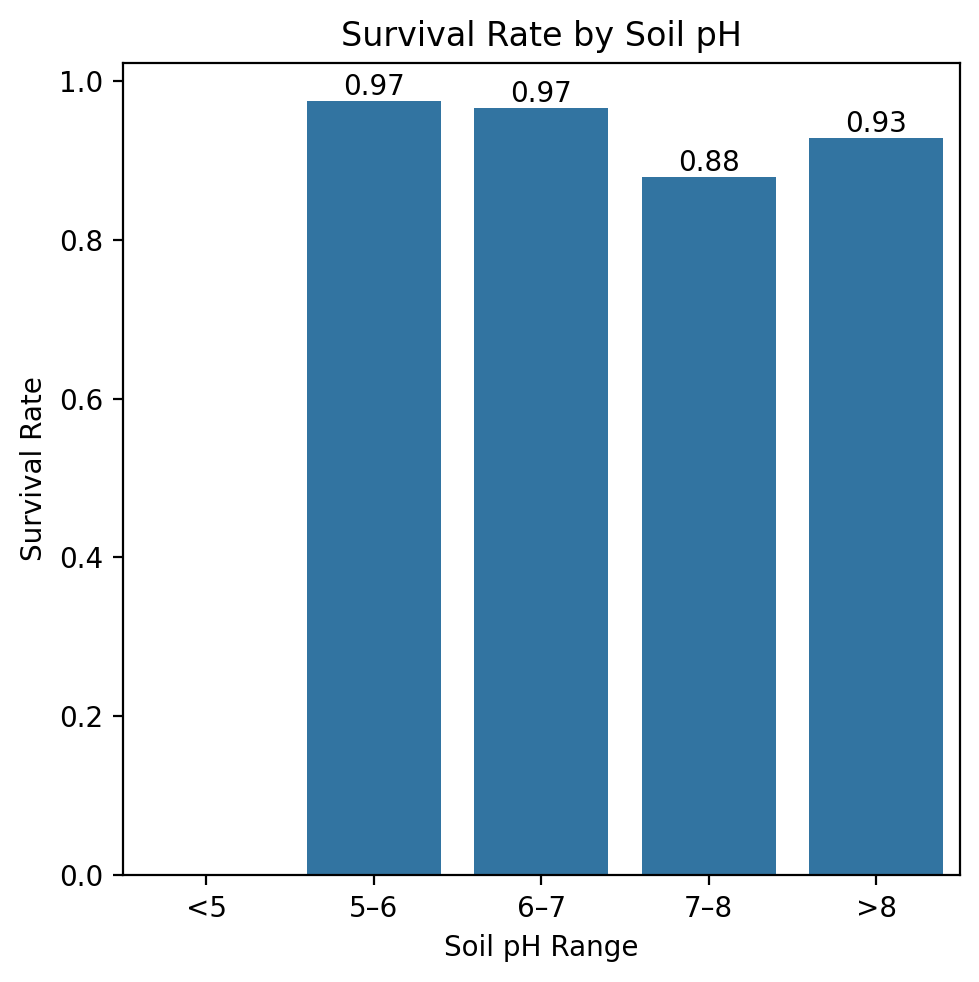

In [40]:
# Create a temporary DataFrame for pH analysis, dropping rows missing the ph data
df_ph = final_df.dropna(subset=["ph"]).copy()

# Bin the continuous ph data into categorical ranges using pandas.cut
df_ph["ph_bin"] = pd.cut(
    df_ph["ph"], bins=[0, 5, 6, 7, 8, 10], labels=["<5", "5–6", "6–7", "7–8", ">8"]
)

# Group the data by ph_bin and calculate the average survival rate for each bin
ph_survival = df_ph.groupby("ph_bin", observed=False)["survived"].mean()

# Initialise the plot size for the visualisation
plt.figure(figsize=(5, 5))

# Create a bar plot using Seaborn, mapping pH bins to the x-axis and mean survival rates to the y-axis
ax = sns.barplot(x=ph_survival.index, y=ph_survival.values)

# Add numerical data labels (survival rates) on top of each bar in the plot
for i, v in enumerate(ph_survival.values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set the labels and title for the chart
plt.ylabel("Survival Rate")
plt.xlabel("Soil pH Range")
plt.title("Survival Rate by Soil pH")
plt.tight_layout()

# Display the generated plot
plt.show()

### Visualise tree survival by rainfall

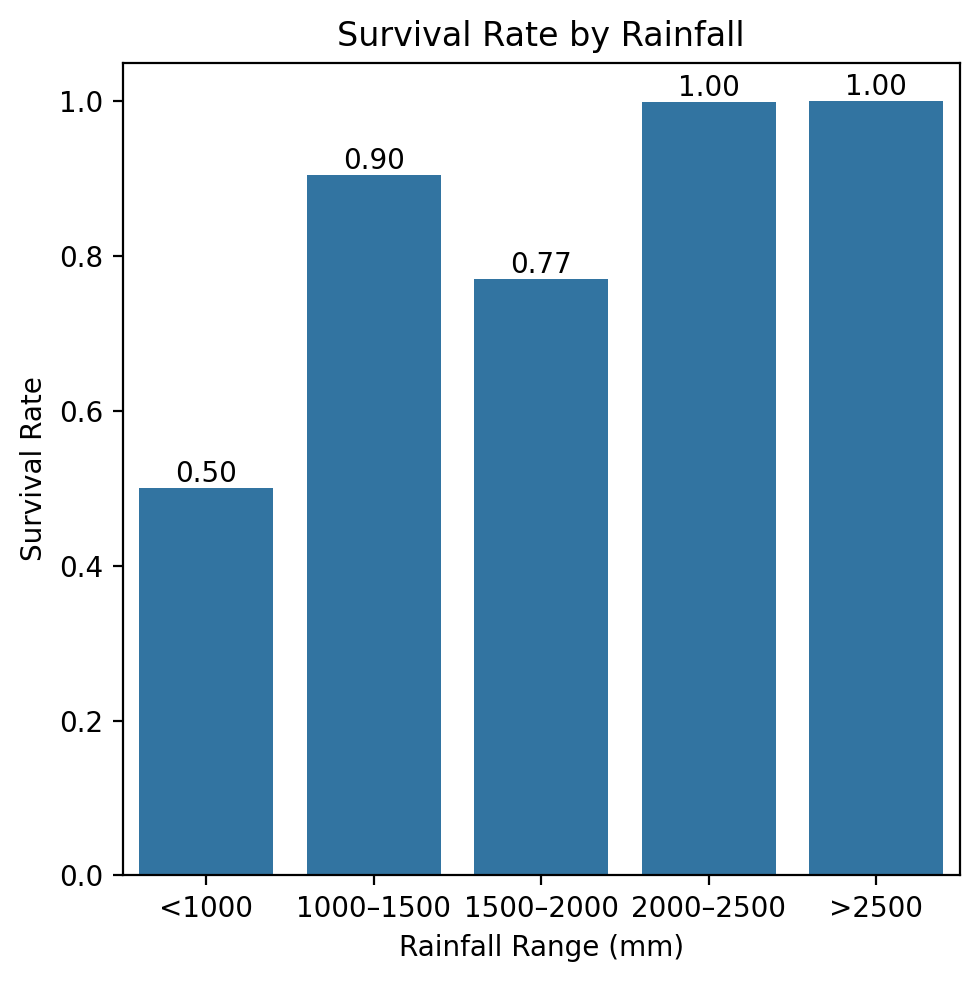

In [42]:
# Create a temporary DataFrame for rainfall analysis, dropping rows missing the rain_mean data
df_rain = final_df.dropna(subset=["rain_mean"]).copy()

# Bin the continuous rain_mean data into categorical ranges using pandas.cut
df_rain["rain_bin"] = pd.cut(
    df_rain["rain_mean"],
    bins=[0, 1000, 1500, 2000, 2500, 3000],
    labels=["<1000", "1000–1500", "1500–2000", "2000–2500", ">2500"],
)

# Group the data by the rain_bin and calculate the average survival rate for each bin
rain_survival = df_rain.groupby("rain_bin", observed=False)["survived"].mean()

# Initialise the plot size for the visualisation
plt.figure(figsize=(5, 5))

# Create a bar plot using Seaborn, mapping rainfall bins to the x-axis and mean survival rates to the y-axis
ax = sns.barplot(x=rain_survival.index, y=rain_survival.values)

# Add numerical data labels (survival rates) on top of each bar in the plot
for i, v in enumerate(rain_survival.values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set the labels and title for the chart
plt.ylabel("Survival Rate")
plt.xlabel("Rainfall Range (mm)")
plt.title("Survival Rate by Rainfall")
plt.tight_layout()

# Display the generated plot
plt.show()

### Visualise tree survival by temperature

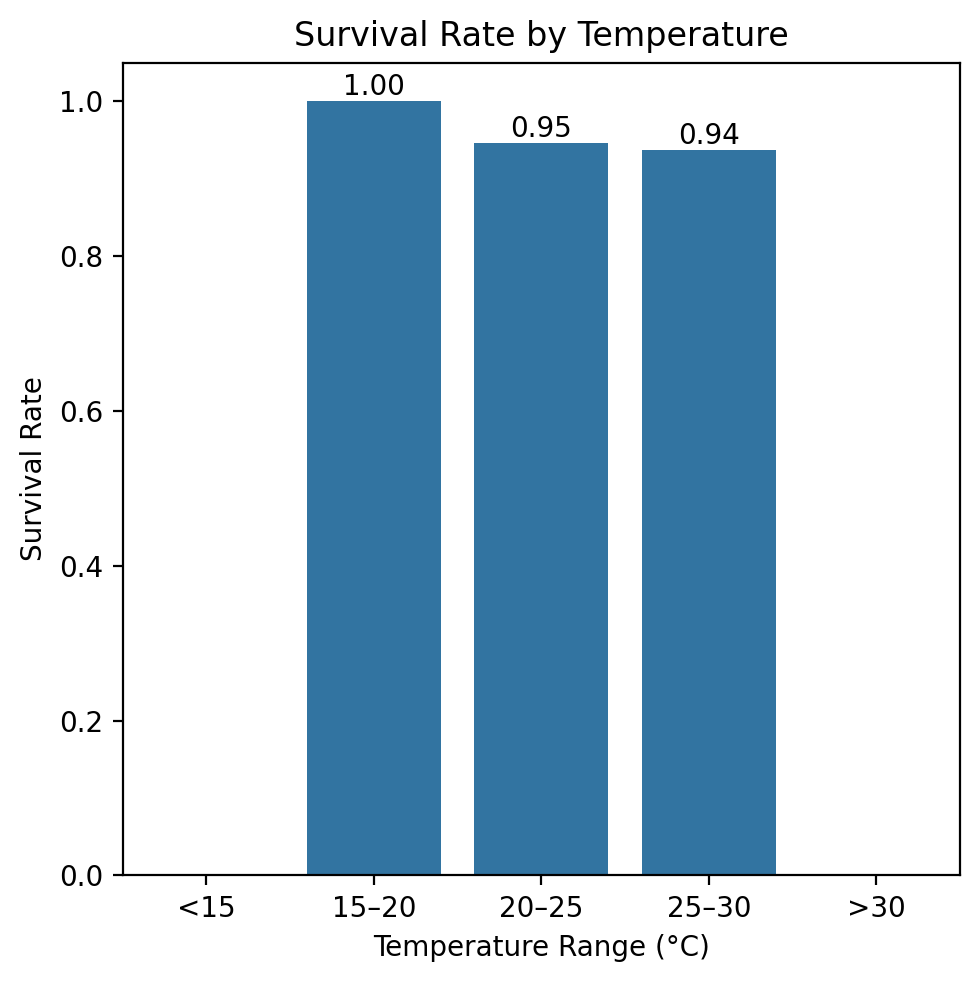

In [44]:
# Create a temporary DataFrame and drop rows missing the temp_mean data required for analysis
df_temp = final_df.dropna(subset=["temp_mean"]).copy()

# Bin the continuous temp_mean data into categorical ranges using pandas.cut
df_temp["temp_bin"] = pd.cut(
    df_temp["temp_mean"],
    bins=[0, 15, 20, 25, 30, 40],
    labels=["<15", "15–20", "20–25", "25–30", ">30"],
)

# Group the data by temp_bin and calculate the average survival rate for each bin
temp_survival = df_temp.groupby("temp_bin", observed=False)["survived"].mean()

# Initialise the plot size for visualisation
plt.figure(figsize=(5, 5))

# Create a bar plot, mapping temperature bins to the x-axis and mean survival rates to the y-axis
ax = sns.barplot(x=temp_survival.index, y=temp_survival.values)

# Add numerical data labels (survival rates) on top of each bar in the plot
for i, v in enumerate(temp_survival.values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# Set the labels and title for the chart
plt.ylabel("Survival Rate")
plt.xlabel("Temperature Range (°C)")
plt.title("Survival Rate by Temperature")
plt.tight_layout()

# Display the generated plot
plt.show()

### Identify key environmental factors that influence tree survival

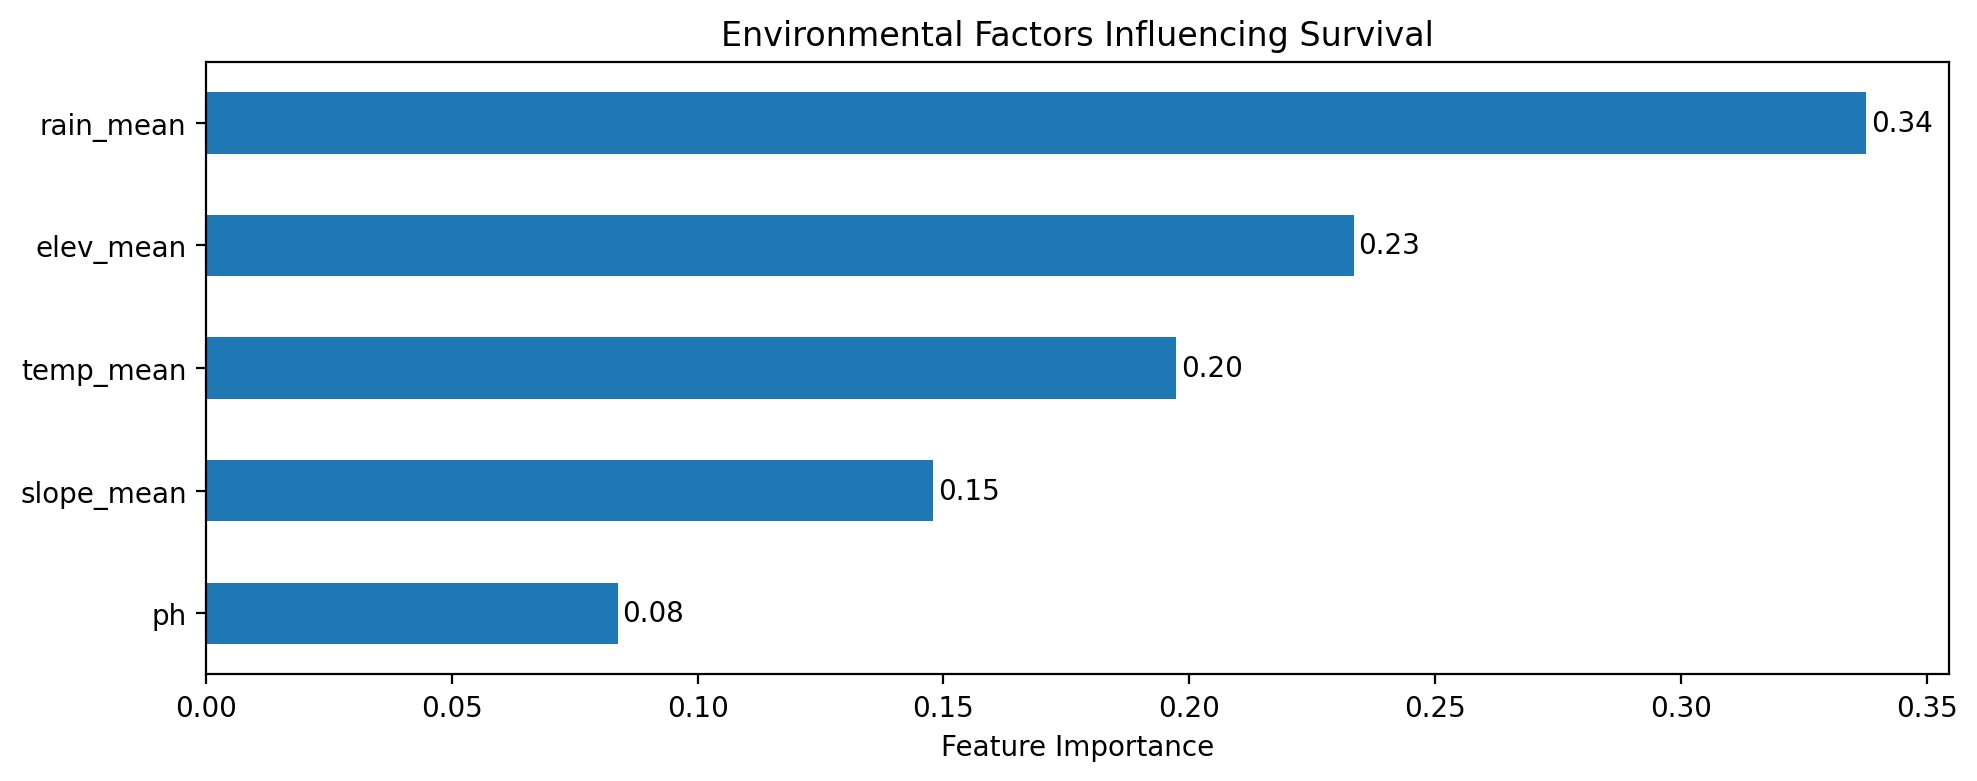

In [46]:
# Define the list of environmental features that will be used for training the model
features = ["temp_mean", "rain_mean", "elev_mean", "slope_mean", "ph"]

# Prepare the modelling dataset by removing any rows where the features or the target variable ("survived") are missing
df_model = final_df.dropna(subset=features + ["survived"])

# Separate the data into predictor variables (X) and the target variable (y)
X = df_model[features]
y = df_model["survived"]

# Split the dataset into training (80%) and testing (20%) sets for model development and evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialise and train a Random Forest classifier model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Calculate and sort the feature importances derived from the trained model
importance = pd.Series(model.feature_importances_, index=features).sort_values(
    ascending=True
)

# Create a horizontal bar chart to visualise the feature importances
plt.figure(figsize=(10, 4))
ax = importance.plot(kind="barh")

# Add the numerical importance value as text labels next to each bar
for i, v in enumerate(importance.values):
    ax.text(v + 0.001, i, f"{v:.2f}", va="center", fontsize=10)

# Add labels and a title to the plot
plt.xlabel("Feature Importance")
plt.title("Environmental Factors Influencing Survival")
plt.tight_layout()

# Display the visualisation
plt.show()

In [47]:
final_df.info()
optima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732219 entries, 0 to 732218
Data columns (total 51 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   fob_id                     732219 non-null  object        
 1   scan_date                  732219 non-null  object        
 2   scanned_to_farmer_id       732219 non-null  object        
 3   farmer_card_id             732219 non-null  object        
 4   planted_year               732219 non-null  int64         
 5   planted_month              732219 non-null  object        
 6   trunk_circumference        229444 non-null  float64       
 7   tree_species               732219 non-null  object        
 8   tree_lat                   732219 non-null  float64       
 9   tree_lon                   732219 non-null  float64       
 10  FobID                      732219 non-null  object        
 11  EarliestScanTimestamp      639340 non-null  object  

### Compare actual farm environmental conditions with species optimal ranges

In [49]:
# Convert the range columns to numeric types in the optima_df
range_cols = [
    "rainfall_min",
    "rainfall_max",
    "temp_min",
    "temp_max",
    "ph_min",
    "ph_max",
    "alt_min",
    "alt_max",
]

optima_df[range_cols] = optima_df[range_cols].apply(pd.to_numeric, errors="coerce")

# Merge the final tree dataset (final_df) with the optimal species ranges
merged = final_df.merge(
    optima_df, left_on="correct_tree_species_name", right_on="species_name", how="left"
)

# Create boolean flags to indicate whether the farm's environmental conditions fall within the specie's optimal ranges
merged["rain_optimal"] = (merged["rain_mean"] >= merged["rainfall_min"]) & (
    merged["rain_mean"] <= merged["rainfall_max"]
)

merged["temp_optimal"] = (merged["temp_mean"] >= merged["temp_min"]) & (
    merged["temp_mean"] <= merged["temp_max"]
)

merged["ph_optimal"] = (merged["ph"] >= merged["ph_min"]) & (
    merged["ph"] <= merged["ph_max"]
)

merged["alt_optimal"] = (merged["elev_mean"] >= merged["alt_min"]) & (
    merged["elev_mean"] <= merged["alt_max"]
)

# Create a summary table grouped by the species name to show the mean survival rate and the proportion of conditions that were optimal
species_alignment_summary = merged.groupby("species_name")[
    ["survived", "rain_optimal", "temp_optimal", "ph_optimal", "alt_optimal"]
].mean()

print("Summary of survival alignment with optimal ranges:")
print(species_alignment_summary)

# Save the full merged dataset
output_path = "/Users/cjaybasa/Downloads/tree_data_full.csv"
merged.to_csv(output_path, index=False)

Summary of survival alignment with optimal ranges:
              survived  rain_optimal  temp_optimal  ph_optimal  alt_optimal
species_name                                                               
Ai-bobur      0.375000      1.000000      0.000000    1.000000     0.375000
Ai-kakeu      0.952143      1.000000      1.000000    0.970470     1.000000
Ai-kamelli    0.940541      0.254054      1.000000    0.745946     1.000000
Ai-mahony     0.932029      0.745099      0.999554    0.309434     1.000000
Ai-na         0.983417      0.864228      0.922462    0.969246     0.039253
Ai-nitas      0.959889      0.049446      1.000000    0.836132     0.999837
Ai-ru         1.000000      0.054531      0.007443    0.998220     0.992557
Ai-saria      0.898904      1.000000      1.000000    0.764110     0.914521
Ai-teka       0.987156      0.317302      1.000000    0.281744     1.000000


### Build a tree survival prediction model

In [51]:
# Define the environmental and species features used for training the prediction model
features = [
    "temp_mean",
    "rain_mean",
    "elev_mean",
    "slope_mean",
    "ph",
    "correct_tree_species_name",
]

# Prepare the final modelling dataset by dropping rows with missing values in features or the target variable ("survived")
df_model = final_df.dropna(subset=features + ["survived"])

# Separate the data into features (X) and the target variable (y)
X = df_model[features]
y = df_model["survived"]

# One-hot encode the categorical 'correct_tree_species_name'
# Pass through all numeric environmental features without transformation
preprocess = ColumnTransformer(
    transformers=[
        (
            "species",
            OneHotEncoder(handle_unknown="ignore"),
            ["correct_tree_species_name"],
        ),
        (
            "numeric",
            "passthrough",
            ["temp_mean", "rain_mean", "elev_mean", "slope_mean", "ph"],
        ),
    ]
)

# Build a machine learning pipeline that first preprocesses the data, then applies a RandomForestClassifier
model_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(n_estimators=200, random_state=42)),
    ]
)

# Train the model using the prepared training data
model_pipeline.fit(X, y)


def generate_warnings(species_name, temp, rain, elev, slope, ph):
    warnings = []

    # Check if the input slope is within the observed range in the final_df
    if not (final_df["slope_mean"].min() <= slope <= final_df["slope_mean"].max()):
        warnings.append(
            "The slope value you entered is outside the observed farm conditions"
        )

    # Get the species-specific optimal range data from the optima_df
    row = optima_df.loc[optima_df["species_name"] == species_name]
    if row.empty:
        warnings.append(
            "The species name you entered was not found in optimal range table"
        )
        return warnings

    r = row.iloc[0]

    # Check if input values are within the specie's optimal ranges
    if not (r["rainfall_min"] <= rain <= r["rainfall_max"]):
        warnings.append(
            "The rainfall value you entered is outside the specie's optimal range"
        )
    if not (r["temp_min"] <= temp <= r["temp_max"]):
        warnings.append(
            "The temperature value you entered is outside the specie's optimal range"
        )
    if not (r["ph_min"] <= ph <= r["ph_max"]):
        warnings.append(
            "The soil pH value you entered is outside the specie's optimal range"
        )
    if not (r["alt_min"] <= elev <= r["alt_max"]):
        warnings.append(
            "The altitude value you entered is outside the specie's optimal range"
        )

    return warnings


# Predicts the survival probability for a given set of conditions using the trained model
# and prints relevant warnings if conditions are sub-optimal or out of observed range.
def predict_survival(species_name, temp, rain, elev, slope, ph):
    # Generate warnings
    warnings = generate_warnings(species_name, temp, rain, elev, slope, ph)

    # Prepare input for the model
    sample = pd.DataFrame(
        [
            {
                "temp_mean": temp,
                "rain_mean": rain,
                "elev_mean": elev,
                "slope_mean": slope,
                "ph": ph,
                "correct_tree_species_name": species_name,
            }
        ]
    )

    # Predict survival probability
    prob = model_pipeline.predict_proba(sample)[0][1]
    prob_percent = round(prob * 100, 2)

    # Output warnings
    for w in warnings:
        print("Note:", w)
    print()

    # Output prediction
    print(
        f"The predicted chance of survival for the '{species_name}' species "
        f"is {prob_percent:.2f}%\n\n"
    )

### Generate example survival prediction

In [53]:
predict_survival(species_name="Ai-bobur", temp=24, rain=1, elev=200, slope=70, ph=5.5)

predict_survival(species_name="Ai-teka", temp=26, rain=1000, elev=180, slope=9, ph=7)

predict_survival(species_name="Ai-mahony", temp=18, rain=3000, elev=180, slope=8, ph=8)

Note: The slope value you entered is outside the observed farm conditions
Note: The rainfall value you entered is outside the specie's optimal range
Note: The temperature value you entered is outside the specie's optimal range
Note: The soil pH value you entered is outside the specie's optimal range

The predicted chance of survival for the 'Ai-bobur' species is 58.39%


Note: The rainfall value you entered is outside the specie's optimal range

The predicted chance of survival for the 'Ai-teka' species is 43.17%


Note: The rainfall value you entered is outside the specie's optimal range
Note: The temperature value you entered is outside the specie's optimal range
Note: The soil pH value you entered is outside the specie's optimal range

The predicted chance of survival for the 'Ai-mahony' species is 99.51%


